In [33]:
%matplotlib inline

import numpy as np

import pandas as pd 
pd.__version__
from lmfit import Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
#import tikzplotlib
import re
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF
from rdflib.plugins.sparql import prepareQuery

from shapely import Polygon, Point
from matolab_tools import annotate_csv_uri, csvw_to_rdf , create_mapping, get_joined_rdf 

#fetch sematic data and query for datasets and rois
PMD_CO=Namespace("https://w3id.org/pmd/co/")
OME=Namespace("https://github.com/Mat-O-Lab/OmeroExtractor/raw/main/ome.ttl#")
QUDT = Namespace("http://qudt.org/schema/qudt/")
OA = Namespace("http://www.w3.org/ns/oa#")
QUDT_UNIT_URL = 'https://raw.githubusercontent.com/qudt/qudt-public-repo/main/vocab/unit/VOCAB_QUDT-UNITS-ALL-v2.1.ttl'
QUNIT = Namespace("http://qudt.org/vocab/unit/")

units_graph = Graph()
units_graph.parse(QUDT_UNIT_URL, format='turtle')


def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

def get_unit_symbol(qudt_unit):
  return str(units_graph.value(qudt_unit,QUDT.symbol))

def get_histogram(y, start=0.0, end=None, bin_width=1.0,x_label='x',plot_result=False) -> pd.DataFrame:
    #num_bins=int((max_x-min_x)/bin_width)
    y_label="normalized count"
    if not end:
       end=max(y)
    # default half open edges, last bin is regular bin_with edge to max(x)
    bin_edges=np.arange(start, end, bin_width)
    count, bin_edges= np.histogram(y,bins=bin_edges)
    
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist=pd.DataFrame({'center': bin_centers, 'count': count})
    hist['norm']=hist['count']/hist['count'].sum()
    if plot_result:
        plt.figure()
        plt.bar(hist['center'], hist['count'], width=bin_width, alpha=0.5,align='center')
        plt.xlabel(x_label)
        plt.ylabel('count')
        plt.show()
    return hist

#log distrubition fumction
def rock(x, rm, sigma):
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

def fit_log_distribution(x, y, x_min=None, x_max=None, y_max=0.0, bin_width=1.0, x_label=r"$x$", y_label=r"probability density", filename='fit_log_distribution.png', save_plot=False) -> dict:
   results=dict()
   if not x_min:
      x_min=0
   if not x_max:
      x_max=max(x)
   x_sim=np.linspace(x_min,x_max,300)
   #https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
   fit=pd.DataFrame(columns=('x','y','dely'))
   model = Model(rock)
   #params = model.make_params(sigma=3.0, rm=1.0)
   params = Parameters()
   #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
   params.add('sigma', value=1, min=0.1, max=100.0,vary=True)
   params.add('rm', value=5.0, min=0.5,max=100, vary=True)
   result = model.fit(y, params, x=x)
   print(result.fit_report())
   
   fit['x']=x_sim
   fit['y']=model.eval(x=x_sim, params=result.params)
   fit['dely'] = result.eval_uncertainty(x=x_sim)
   results['chi squared']=result.chisqr
   # results.at[key,'R squared']=result.rsquared
   # results.at[key,'amplitude']=result.params['amp'].value
   # results.at[key,'amplitude stderr']=result.params['amp'].stderr
   results['rm']=result.params['rm'].value
   results['rm stderr']=result.params['rm'].stderr
   results['sigma']=result.params['sigma'].value
   results['sigma stderr']=result.params['sigma'].stderr
   results['ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
   results['ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
   results['n_bins']=len(x)
   results['start']=x_min
   results['end']=x_max
   results['bin_width']=bin_width
   results['fit']=fit
   fig=plt.figure()
   plt.tight_layout()
   ax=plt.axes()
   #ax.set_facecolor((.94, .94, .94))
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   #ax.yaxis.grid(True, color='#EEEEEE')
   #ax.xaxis.grid(False)
   plt.title(r"log normal fit $r_m={:.2f}\pm{:.2f}$, $\sigma={:.2f}\pm{:.2f}$".format(result.params['rm'].value,result.params['rm'].stderr,result.params['sigma'].value,result.params['sigma'].stderr))
   bars=ax.bar(x, y, width=bin_width, alpha=0.5,align='center', linewidth=0.2, edgecolor='gray')
   plt.plot(fit['x'], fit['y'], label='fit')
   plt.fill_between(fit['x'], fit['y']-fit['dely'],
         fit['y']+fit['dely'], color='#888888',alpha=0.3)
   plt.xlabel(x_label)
   plt.xlim(left=x_min,right=x_max)
   plt.ylim(bottom=0)
   bar_color = bars[0].get_facecolor()
   # for bar in bars:
   #    ax.text(
   #       bar.get_x() + bar.get_width() / 2,
   #       bar.get_height(),
   #       round(bar.get_height(), 1),
   #       horizontalalignment='center',
   #       color=bar_color,
   #       weight='bold'
   #    )
   if y_max:
      plt.ylim(top=y_max)
   
   #plt.xticks(x)
   plt.ylabel(y_label)
   plt.show()
   if save_plot:
      fig.savefig(filename)
   plt.close(fig)   
   return results

meta=Graph()
meta.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
#meta.parse("./detection_runs-joined.ttl")
#add inverse relations
for s,p,o in meta.triples((None,PMD_CO.isResourceOf,None)):
   meta.add((o,PMD_CO.resource,s))
for s,p,o in meta.triples((None,PMD_CO.characteristic,None)):
   meta.add((o,PMD_CO.characteristicOf,s))
#meta.serialize('detection_runs-joined.ttl')

# Distribution Formula
$$X = \frac{1}{\sqrt{2 \pi} x \sigma} \exp{\left(-\frac{(\ln{x}-\ln{r_m})^2}{2 \sigma^2}\right)}$$

In [2]:
#fetching data from joined graph
q = prepareQuery(
    """
    SELECT ?ome_image ?ome_rois ?specimen_label ?chartype ?charvalue ?charunit WHERE 
    {
          ?image rdf:type co:Image ;
            co:resource ?ome_image.
          ?image_process co:output ?image ;
            co:nextProcess ?analysis_process ;
            co:input ?specimen .
          ?analysis_process co:output ?rois.
          ?rois co:resource ?ome_rois.
          ?creep_process co:nextProcess ?image_process;
            co:input [ a ?chartype;
              co:resource / qudt:value ?charvalue;
              co:resource / qudt:unit ?charunit].
          ?specimen co:characteristic [ a co:SpecimenName;
              co:resource / oa:hasBody / oa:value ?specimen_label].
    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME, "rdf": RDF, "oa": OA, "qudt": QUDT}
)
qres = meta.query(q)
#print(list(qres)[:10])
df = pd.DataFrame(qres, columns =["ome_image", "ome_rois", "specimen_label", "parameter", "value", "unit"])
#remove rows names individual
df = df[df["parameter"] != URIRef("http://www.w3.org/2002/07/owl#NamedIndividual")]
result=df.iloc[:,0:3]#.set_index("ome_image")
params=df.loc[:,['ome_image',"parameter","value", "unit"]].set_index(["ome_image","parameter"])
params=params.unstack().reset_index()
params.columns = [' '.join((str2.rsplit('/',1)[-1],str1)).strip() for (str1,str2) in params.columns.values]

result.set_index('ome_image',inplace=True)
params.set_index('ome_image',inplace=True)
result=pd.concat([result, params.reindex(result.index)], axis=1).drop_duplicates()
#result['AgingTemperature unit symbol']=result['AgingTemperature unit'].map(get_unit_symbol)
result
result['dataset']= "T"+result['AgingTemperature value'].astype(str)+result['AgingTemperature unit'].map(get_unit_symbol)+'_'\
  "D"+result['AgingTime value'].astype(str)+result['AgingTime unit'].map(get_unit_symbol)+'_'\
  "S"+result['CreepStress value'].astype(str)+result['CreepStress unit'].map(get_unit_symbol)
data=result.reset_index().set_index(['dataset','ome_image']).to_dict('index')
data.keys()
data_dict=dict()
#data_dict={ dataset: {} for (dataset, index) in data.keys()}
for (dataset, index),value in data.items():
  if dataset not in data_dict.keys():
    data_dict[dataset]=dict()
  data_dict[dataset][index]=value
#data_dict

In [3]:
#fetch physical size of images
q = prepareQuery(
    """
    SELECT ?image ?sizex_value ?sizex_unit ?sizey_value ?sizey_unit WHERE 
    {
        ?image ome:relates_to / ome:physicalSizeX ?sizex ;
            ome:relates_to / ome:physicalSizeY ?sizey.
        ?sizex qudt:value ?sizex_value;
            qudt:unit ?sizex_unit.
        ?sizey qudt:value ?sizey_value;
            qudt:unit ?sizey_unit.
    }
    """
    ,
    initNs = { "qudt": QUDT, "ome": OME}
)
#df = pd.DataFrame(qres, columns =["image", "ome_image", "image_ds", "ome_image_ds", "rois", "ome_rois"])
pysicalsizes=dict()
for dataset, content in data_dict.items():
    images_graph=Graph()
    for image in content.keys():
        images_graph.parse(image,format='json-ld')
    qres = images_graph.query(q)
    df=pd.DataFrame(qres,columns =["image","sizex", "xunit", "sizey", "yunit"])
    df.set_index('image',inplace=True)
    pysicalsizes[dataset]=df
#pysicalsizes

In [4]:
# reshape countour data and calculate the polygon properties centroid, area, radius
poly_dict=dict()
for dataset, content in data_dict.items():
    contour_list=list()
    print("accessing {} with {} rois.".format(dataset,len(content)))
    rois=list()
    for image,record in content.items():
        shape_graph=Graph()
        rois.append(record['ome_rois'])
        shape_graph.parse(record['ome_rois'],format='json-ld')
        polygons_meta=shape_graph.subjects(RDF.type,OME.Polygon)
        #image_id=record['ome_rois'].rsplit('/',1)[-1]
        #reshape data
        contour_data=[shape_graph.value(polygon,OME.points).split(' ') for polygon in polygons_meta]
        contour_data=[[point.split(',')for point in contour] for contour in contour_data]
        #to pysical coords
        scale=[float(pysicalsizes[dataset].loc[image]['sizex']),float(pysicalsizes[dataset].loc[image]['sizey'])]
        contour_data=[np.array(contour).astype('float64')*scale for contour in contour_data]
        print("{} contours with scale {} for {} image".format(len(contour_data),scale,image))
        contour_list+=contour_data
    #print(np.array(contour_data[0]))
    #calc polygon charakteristics
    polygon_props=list()
    polygons=[Polygon(contour) for contour in contour_list]
    for polygon in polygons:
        # calculate the distance from the centroid to each vertex
        centroid=Point(polygon.centroid)
        distances = [centroid.distance(Point(vertex)) for vertex in polygon.exterior.coords]
        # calculate the mean radius of the polygon, as mean of distance from centrois to exterior points
        mean_radius_edge = sum(distances) / len(distances)
        mean_radius_circle_area = np.sqrt(polygon.area/np.pi)
        polygon_props.append({'area': polygon.area, 'centroid': polygon.centroid, 'mean_radius_edge_distance': mean_radius_edge, 'mean_radius_circle_area': mean_radius_circle_area })
    df=pd.DataFrame(polygon_props)
    print('characterized {} polygons'.format(len(df)))
    poly_dict[dataset]={"dataframe": df, 'rois': rois}


accessing T190.0°C_D1000.0hr_S0MPa with 12 rois.
33 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/83 image
98 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/84 image
111 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/81 image
73 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/82 image
100 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/85 image
52 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/74 image
34 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/75 image
63 contours with scale [0.14642348885536194, 0.14642348885536194] for https://met

calculating distribution of T190.0°C_D1000.0hr_S0MPa with 718 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 13
    # variables        = 2
    chi-square         = 7.8665e-04
    reduced chi-square = 7.1514e-05
    Akaike info crit   = -122.264752
    Bayesian info crit = -121.134854
    R-squared          = 0.99403437
[[Variables]]
    sigma:  1.20870494 +/- 0.04023286 (3.33%) (init = 1)
    rm:     1.90269004 +/- 0.04939108 (2.60%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2708


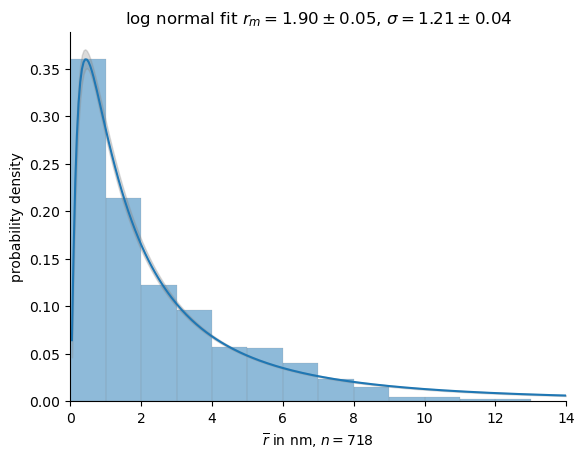

calculating distribution of T190.0°C_D8760.0hr_S0MPa with 637 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 26
    # variables        = 2
    chi-square         = 0.00856632
    reduced chi-square = 3.5693e-04
    Akaike info crit   = -204.468339
    Bayesian info crit = -201.952146
    R-squared          = 0.92006904
[[Variables]]
    sigma:  1.39569672 +/- 0.11698705 (8.38%) (init = 1)
    rm:     2.85551080 +/- 0.24634284 (8.63%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.4549


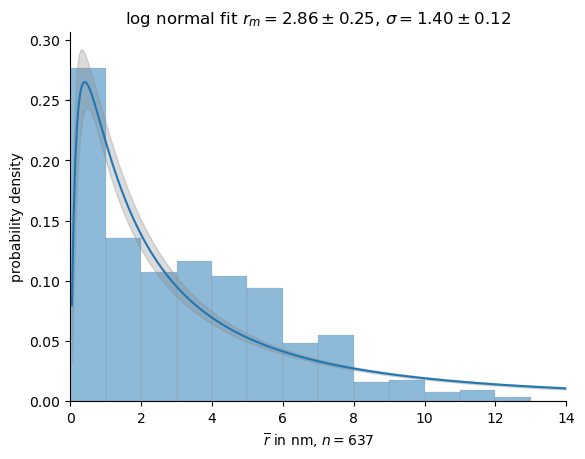

calculating distribution of T23.0°C_D0.0hr_S0MPa with 1644 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00166782
    reduced chi-square = 1.6678e-04
    Akaike info crit   = -102.573736
    Bayesian info crit = -101.603923
    R-squared          = 0.99253903
[[Variables]]
    sigma:  0.56447252 +/- 0.01487850 (2.64%) (init = 1)
    rm:     1.38219955 +/- 0.02964149 (2.14%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.7803


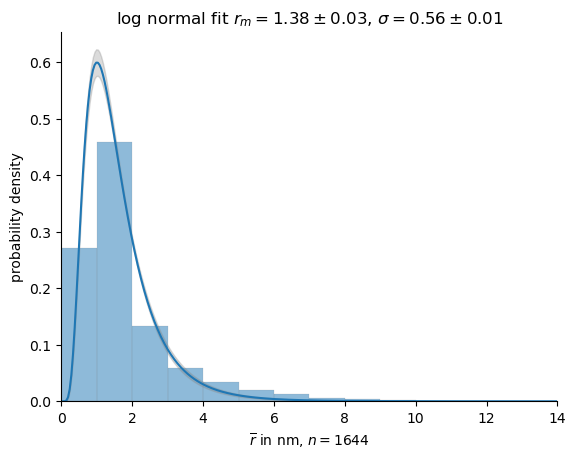

calculating distribution of T190.0°C_D25000.0hr_S0MPa with 464 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 30
    # variables        = 2
    chi-square         = 0.00351450
    reduced chi-square = 1.2552e-04
    Akaike info crit   = -267.561669
    Bayesian info crit = -264.759274
    R-squared          = 0.98197840
[[Variables]]
    sigma:  1.67048653 +/- 0.07307274 (4.37%) (init = 1)
    rm:     1.10070360 +/- 0.13611869 (12.37%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.7261


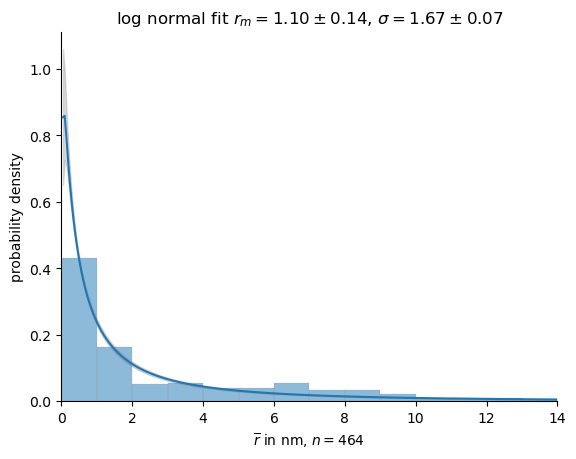

calculating distribution of T190.0°C_D2500.0hr_S0MPa with 721 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 21
    # variables        = 2
    chi-square         = 0.00259208
    reduced chi-square = 1.3643e-04
    Akaike info crit   = -184.996140
    Bayesian info crit = -182.907095
    R-squared          = 0.97439895
[[Variables]]
    sigma:  1.25094801 +/- 0.05725504 (4.58%) (init = 1)
    rm:     2.65903290 +/- 0.12624038 (4.75%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5481


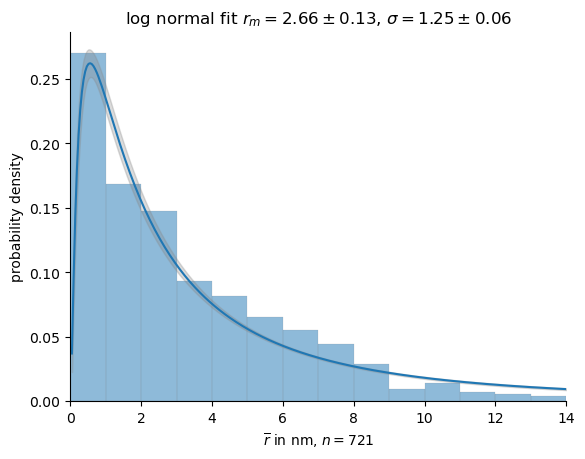

calculating distribution of T190.0°C_D250.0hr_S0MPa with 918 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 22
    # variables        = 2
    chi-square         = 0.00103456
    reduced chi-square = 5.1728e-05
    Akaike info crit   = -215.226105
    Bayesian info crit = -213.044021
    R-squared          = 0.99421695
[[Variables]]
    sigma:  1.18975893 +/- 0.03328852 (2.80%) (init = 1)
    rm:     1.74531352 +/- 0.03602598 (2.06%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.1480


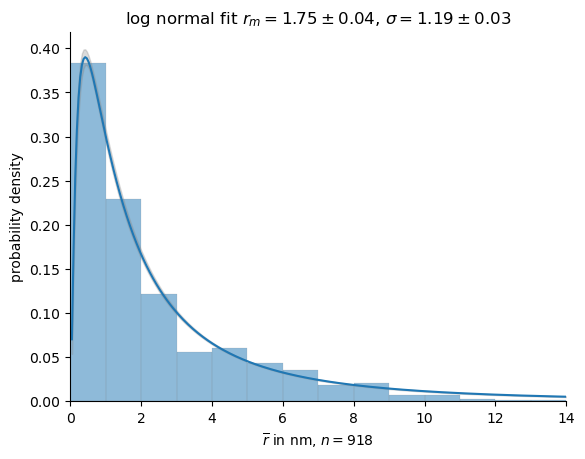

calculating distribution of T190.0°C_D5000.0hr_S0MPa with 1391 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 59
    # variables        = 2
    chi-square         = 7.7344e-04
    reduced chi-square = 1.3569e-05
    Akaike info crit   = -659.290004
    Bayesian info crit = -655.134929
    R-squared          = 0.99733585
[[Variables]]
    sigma:  1.40428035 +/- 0.01747437 (1.24%) (init = 1)
    rm:     0.96291262 +/- 0.02767477 (2.87%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = -0.7332


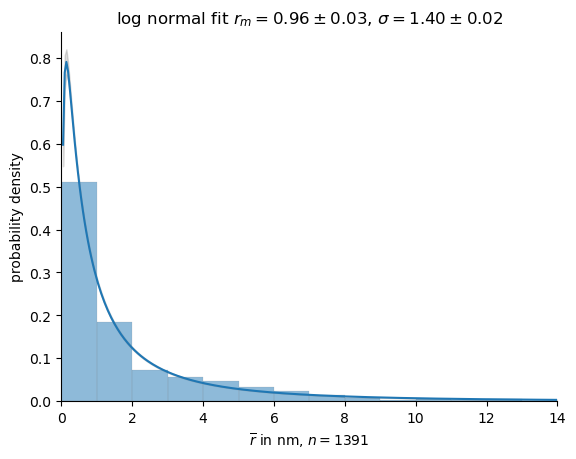

,rois,chi squared,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,n_bins,start,end,bin_width
dataset,,,,,,,,,,,,
T190.0°C_D1000.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/83...,0.000787,1.902690,0.049391,1.208705,0.040233,3.950146,0.102540,13,0,14.0,1.0
T190.0°C_D8760.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/26...,0.008566,2.855511,0.246343,1.395697,0.116987,7.562754,0.652433,26,0,14.0,1.0
T23.0°C_D0.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/51...,0.001668,1.382200,0.029641,0.564473,0.014879,1.620915,0.034761,12,0,14.0,1.0
T190.0°C_D25000.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/14...,0.003514,1.100704,0.136119,1.670487,0.073073,4.442478,0.549380,30,0,14.0,1.0
T190.0°C_D2500.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/86...,0.002592,2.659033,0.126240,1.250948,0.057255,5.814751,0.276061,21,0,14.0,1.0
T190.0°C_D250.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/72...,0.001035,1.745314,0.036026,1.189759,0.033289,3.542021,0.073113,22,0,14.0,1.0
T190.0°C_D5000.0hr_S0MPa,https://metadata.omero.matolab.org/api/rois/11...,0.000773,0.962913,0.027675,1.404280,0.017474,2.581083,0.074182,59,0,14.0,1.0


In [34]:
#ignoring zero division for fit, cause it can happen while iterating
np.seterr(divide='ignore',invalid='ignore')
# create histogram and fit distrbution to found polygon areas
fits=list()
for dataset, content in poly_dict.items():
    dataframe=content['dataframe']
    print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
    #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)
    histogram=get_histogram(dataframe['mean_radius_circle_area'],)
    #remive all special chars
    filename=''.join(e for e in dataset if e.isalnum())
    filename="images/{}.png".format(filename)
    xlabel=r"$\overline{r}$ in nm, $n=$"+str(len(dataframe))
    record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'],x_min=0.0, x_max=14.0, x_label=xlabel, filename=filename,save_plot=True)}
    #record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'])}
    record.pop('fit')
    fits.append({**{'dataset': dataset, "rois": " ".join(content['rois'])},**record})
fit_results=pd.DataFrame(fits).set_index('dataset')
fit_results.to_csv('fit_results.csv')
fit_results

In [6]:
# annotate fit_results.csv
response=annotate_csv_uri("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.csv")

csvw annotation file created, suggested name: fit_results-metadata.json
wrote csvw meta data to fit_results-metadata.json


In [7]:
# serialize table to rdf, uses already commited files on main branch
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
response=csvw_to_rdf(meta_url)

writen serialized table to fit_results.ttl


In [8]:
# create a rule bases mapping between the data in detection_runs and the precipitate analysis knowledge graph 
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
method_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/StatisticalAnalysisWorkflow.ttl"
d_classes= [
    "http://www.w3.org/ns/oa#Annotation",''
    "http://www.w3.org/ns/csvw#Column"
]
m_classes=["https://w3id.org/pmd/co/ValueObject",]
pred="https://w3id.org/pmd/co/isResourceOf"
map_dict={
    "precipitateRegions": "table-1-Rois",
    "ImageSetName": "table-1-Dataset",
    "binWidth": "table-1-BinWidth",
    "x-Max": "table-1-End",
    "x-Min": "table-1-Start",
    "chisqrd": "table-1-ChiSquared",
    "r_a": "table-1-Ra",
    "r_m": "table-1-Rm",
    "sigma": "table-1-Sigma",
    "stderr_r_a": "table-1-RmStderr",
    "stderr_r_a": "table-1-RaStderr",
    "stderr_sigma": "table-1-SigmaStderr",
}
create_mapping(meta_url=meta_url,method_url=method_url,data_super_classes=d_classes,predicate=pred,method_super_classes=m_classes,map_dict=map_dict)

writen mapping file to fit_results-map.yaml


True

In [9]:
# join all data and replicate template knowledge graph for every row in table
mapping_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-map.yaml"
data_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.ttl"
duplicate_for_table = True
get_joined_rdf(map_url=mapping_url,data_url=data_url,duplicate_for_table=duplicate_for_table)


applied 11 mapping rules and skipped 0
wrote joint graph to fit_results-joined.ttl


In [10]:
#merge all metadata together
df_graph=Graph()
df_graph.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
df_graph.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-joined.ttl",format='turtle')
#df_graph.parse("fit_results-joined.ttl",format='turtle')
df_graph.serialize('./df-tem-paw-all.ttl',format='turtle')

<Graph identifier=Nc7ca4d746322402a8ca4944831da59e3 (<class 'rdflib.graph.Graph'>)>

In [11]:
#plot all histograms
title='precipitate size distribution'
plt.figure()
for dataset, dataframe in poly_dict.items():
  histogram=get_histogram(dataframe['mean_radius_circle_area'])
  plt.bar(histogram['center'],histogram['norm'], width=1.0, alpha=0.5,align='center',label=dataset)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  model = Model(rock)
  params = Parameters()
  params.add('rm', value=fit_results.at[dataset,'rm'])
  params.add('sigma', value=fit_results.at[dataset,'sigma'])
  x_sim=np.linspace(0,12.0,300)
  sim=model.eval(x=x_sim, params=params)
  #plt.plot(x_sim, rock(x_sim, rm=fit_results.at[dataset,'rm'],sigma=fit_results.at[dataset,'sigma']), label=dataset+'-eval')
  plt.plot(x_sim, sim, label=dataset+'-eval')
  #plt.fill_between(x_sim, sim-dsim,
  #              sim+dsim, color='#888888',alpha=0.3)
  #break
plt.title(title)
plt.xlabel('mean_radius')
plt.ylabel('norm count')
plt.legend()
plt.show()
  #tikzplotlib.save("{}.tex".format(title.replace(' ','_')))

KeyError: 'mean_radius_circle_area'

<Figure size 640x480 with 0 Axes>

In [ ]:
# reproduce original data
datasets={
    't61': "./original_data/RockT61.csv",
    'T190.0°C_D250.0hr_S0MPa': "./original_data/T1900CD2500hrS0MPa.csv",
    'T190.0°C_D1000.0hr_S0MPa': "./original_data/T1900CD10000hrS0MPa.csv",
    'T190.0°C_D2500.0hr_S0MPa': "./original_data/T1900CD25000hrS0MPa.csv",
    'T190.0°C_D5000.0hr_S0MPa': "./original_data/T1900CD50000hrS0MPa.csv",
    'T190.0°C_D8760.0hr_S0MPa': "./original_data/T1900CD87600hrS0MPa.csv",
    'T190.0°C_D1000.0hr_S0MPa': "./original_data/T1900CD250000hrS0MPa.csv"
    }
# #ignoring zero division for fit, cause it can happen while iterating
# np.seterr(divide='ignore',invalid='ignore')
# # create histogram and fit distrbution to found polygon areas
# fits=list()
# for dataset, content in poly_dict.items():
#     dataframe=content['dataframe']
#     print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
#     #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)
#     histogram=get_histogram(dataframe['mean_radius_circle_area'],)
#     #remive all special chars
#     filename=''.join(e for e in dataset if e.isalnum())
#     filename="images/{}.png".format(filename)
#     xlabel=r"$\overline{r}$ in nm, $n=$"+str(len(dataframe))
#     record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'],x_min=0.0, x_max=14.0, x_label=xlabel, filename=filename,save_plot=True)}
#     #record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'])}
#     record.pop('fit')
#     fits.append({**{'dataset': dataset, "rois": " ".join(content['rois'])},**record})
# fit_results=pd.DataFrame(fits).set_index('dataset')
# fit_results.to_csv('fit_results.csv')
# fit_results